In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mlp
import random as random 
import scipy.optimize as optimize
import glob
import os
import statistics
from scipy.stats import norm, t
import time
%matplotlib inline

mlp.rcParams['figure.dpi']=300

In [2]:
ind = pd.read_csv("ind30.csv", header=0, index_col=0)/100
ind.index = pd.to_datetime(ind.index, format="%Y%m").to_period('M')
ind.columns = ind.columns.str.strip()
ind.head()

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
1926-07,0.0056,-0.0519,0.0129,0.0293,0.1097,-0.0048,0.0808,0.0177,0.0814,0.0039,...,0.0083,0.0922,0.0206,0.0770,0.0193,-0.2379,0.0007,0.0187,0.0037,0.0520
1926-08,0.0259,0.2703,0.0650,0.0055,0.1001,-0.0358,-0.0251,0.0425,0.0550,0.0814,...,0.0217,0.0202,0.0439,-0.0238,0.0488,0.0539,-0.0075,-0.0013,0.0446,0.0676
1926-09,0.0116,0.0402,0.0126,0.0658,-0.0099,0.0073,-0.0051,0.0069,0.0533,0.0231,...,0.0241,0.0225,0.0019,-0.0554,0.0005,-0.0787,0.0025,-0.0056,-0.0123,-0.0386
1926-10,-0.0306,-0.0331,0.0106,-0.0476,0.0947,-0.0468,0.0012,-0.0057,-0.0476,0.0100,...,-0.0011,-0.0200,-0.0109,-0.0508,-0.0264,-0.1538,-0.0220,-0.0411,-0.0516,-0.0849
1926-11,0.0635,0.0729,0.0455,0.0166,-0.0580,-0.0054,0.0187,0.0542,0.0520,0.0311,...,0.0163,0.0377,0.0364,0.0384,0.0160,0.0467,0.0652,0.0433,0.0224,0.0400


## Expected Returns and the Covariance Matrix
Generating the efficient frontier requires a set of expected returns and a covariance matrix. For now, let's assume that we can estiamte these simply by looking back in time and naively assuming they will hold in the future. Clearly, they will not, but we will have plenty of time to dig into that in future lectures. For the moment, assume that our naive method of estimating these parameters will suffice.

We can generate an estimate of expected returns using the annualize_rets() function, that returns a vector of expected returns. For instance, let's generate the set of expected returns based on historic returns from the 5 year period from 1996 through 2000:

In [3]:
def annualize_rets(r, periods_per_year):
    """
    Annualizes a set of returns
    We should infer the periods per year
    but that is currently left as an exercise
    to the reader :-)
    """
    compounded_growth = (1+r).prod()
    n_periods = r.shape[0]
    return compounded_growth**(periods_per_year/n_periods)-1

def annualize_vol(r, periods_per_year):
    """
    Annualizes the vol of a set of returns
    We should infer the periods per year
    but that is currently left as an exercise
    to the reader :-)
    """
    return r.std()*(periods_per_year**0.5)

def sharpe_ratio(r, riskfree_rate, periods_per_year):
    """
    Computes the annualized sharpe ratio of a set of returns
    """
    # convert the annual riskfree rate to per period
    rf_per_period = (1+riskfree_rate)**(1/periods_per_year)-1
    excess_ret = r - rf_per_period
    ann_ex_ret = annualize_rets(excess_ret, periods_per_year)
    ann_vol = annualize_vol(r, periods_per_year)
    return ann_ex_ret/ann_vol

In [4]:
er = annualize_rets(ind["1996":"2000"], 12)
cov = ind["1996":"2000"].cov()

In [5]:
def portfolio_return(weights, returns):
    """
    Computes the return on a portfolio from constituent returns and weights
    weights are a numpy array or Nx1 matrix and returns are a numpy array or Nx1 matrix
    """
    return weights.T @ returns

def portfolio_vol(weights, covmat):
    """
    Computes the vol of a portfolio from a covariance matrix and constituent weights
    weights are a numpy array or N x 1 maxtrix and covmat is an N x N matrix
    """
    return (weights.T @ covmat @ weights)**0.5

## Simulation

### Two asset case

In [6]:
def sim_ef2(n_points, er, cov):
    """
    Simulates the 2-asset portfolio returns and volatility
    """
    if er.shape[0] != 2 or er.shape[0] != 2:
        raise ValueError("plot_ef2 can only plot 2-asset frontiers")
    
    weights = [np.array([w, 1-w]) for w in np.linspace(0, 1, n_points)]
    rets = [portfolio_return(w, er) for w in weights]
    vols = [portfolio_vol(w, cov) for w in weights]
    ef = pd.DataFrame({
        "Returns": rets, 
        "Volatility": vols
    })
    return ef.plot.line(x="Volatility", y="Returns", style=".-", xlim=[min(vols)*0.9,max(vols)*1.1])

<AxesSubplot:xlabel='Volatility'>

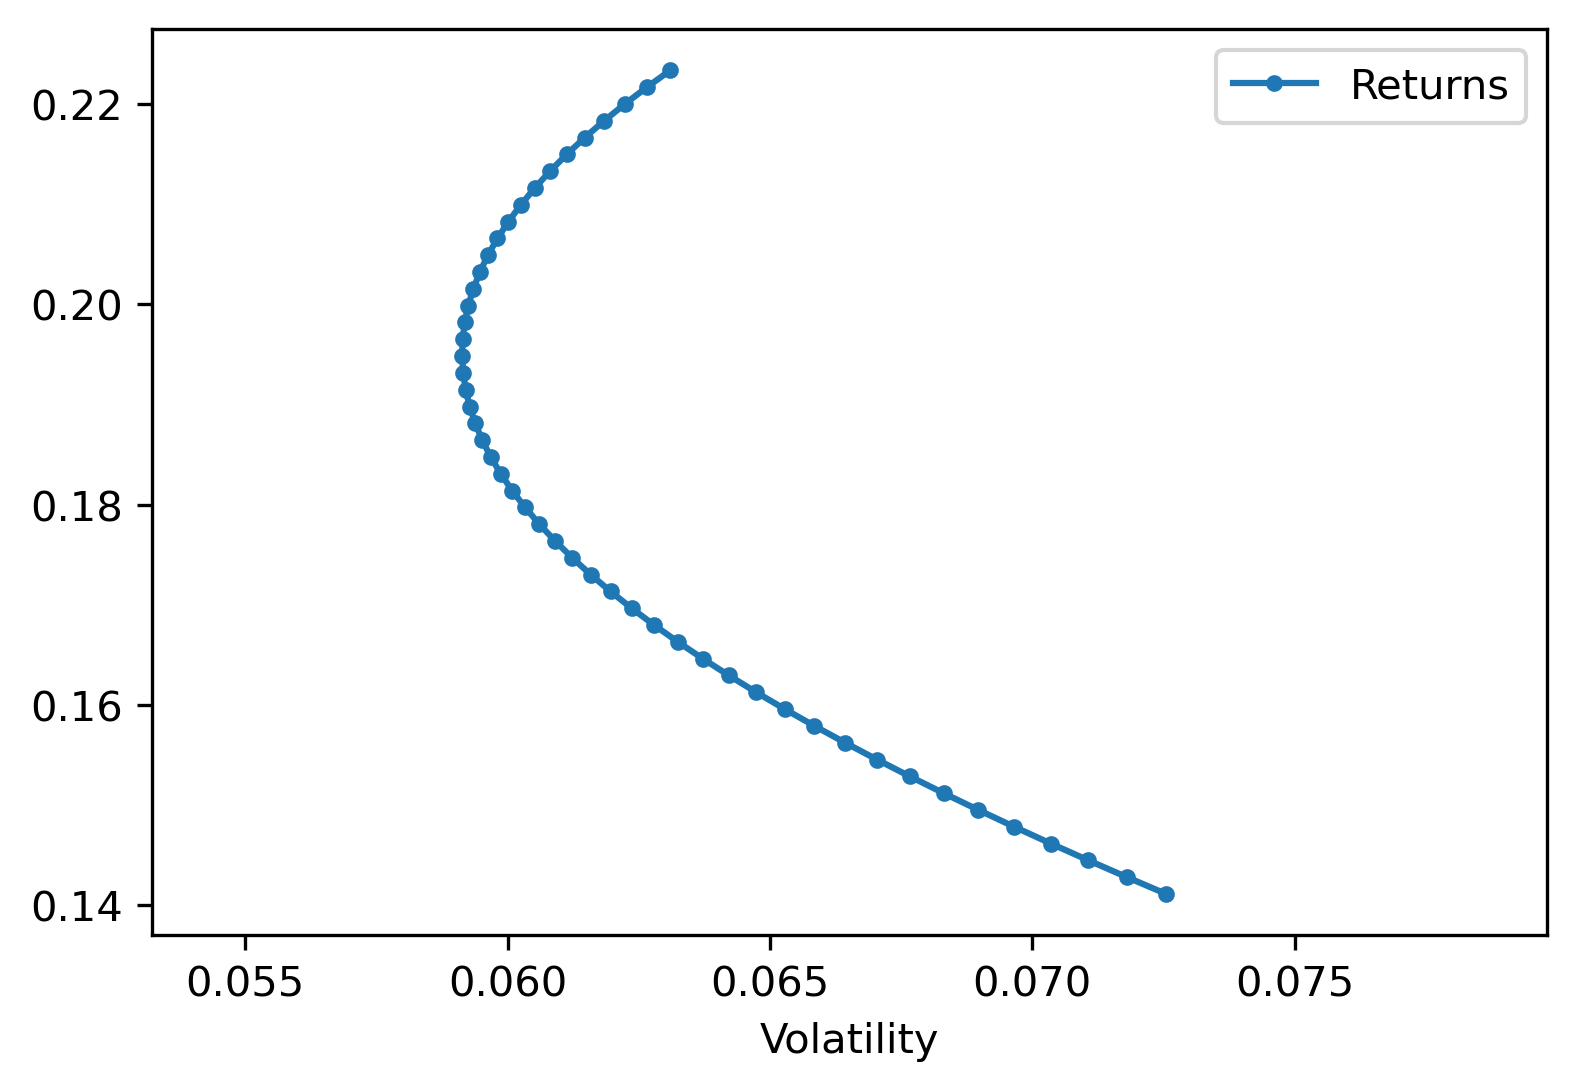

In [7]:
l = ["Fin", "Beer"]
sim_ef2(50, er[l].values, cov.loc[l,l])

### Multiple Assets Simulation (Required)

#### Function For gen Weight

In [8]:
"""
def getWeightN(n_points,x_count):
    weights = []
    lo_temp = [0] * x_count
    for p in range(0,n_points):
        lo_temp = np.array(np.random.random(x_count))
        weights.append(np.array([x/np.sum(lo_temp) for x in lo_temp]))
    return weights
"""
def getWeightN(n_points,x_count):
    weights = np.array([np.random.dirichlet((w,)*x_count, size=1)[0] for w in np.linspace(0.01, 1.5, n_points)])
    return weights

#### Function For Sim N of Asset

In [9]:
def sim_efN(n_points, er, cov):
    weights = getWeightN(n_points,er.shape[0])
    
    rets = [portfolio_return(w, er) for w in weights]
    vols = [portfolio_vol(w, cov) for w in weights]
    ef = pd.DataFrame({
        "Returns": rets, 
        "Volatility": vols
    })
    ef.plot(x="Volatility", y="Returns", xlim=[min(vols)*0.9,max(vols)*1.1],style=".",ms=1)
    plt.show()
    
    return 

#### Plot random N assets 

['Servs', 'Carry', 'Mines']


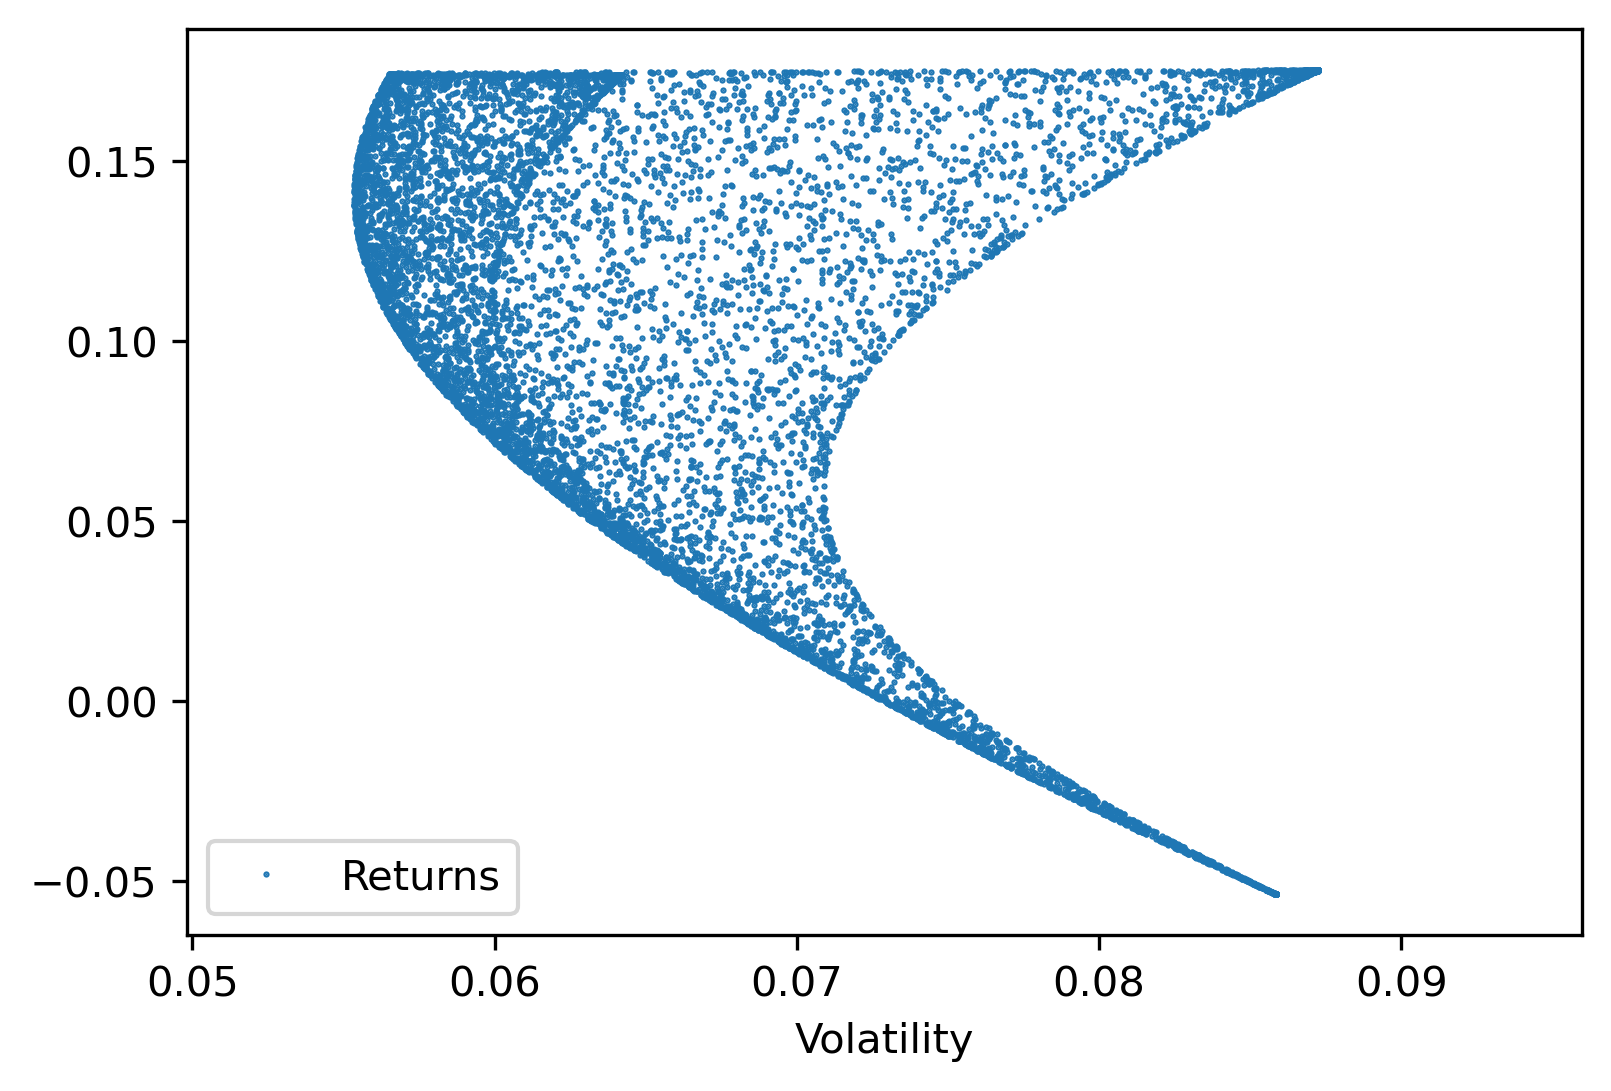

In [10]:
for j in range(1):
    lo_assests = 3
    l = random.sample(list(ind.columns),lo_assests)
    print(l)
    sim_efN(10000, er[l].values, cov.loc[l,l])


### Replace with equity and bond ETFs (Required)

In [11]:
col_list = ["Date", "Adj Close"]
path = "ETF/*.csv"
etf_result = None

for fname in glob.glob(path):
    etf_new = pd.read_csv(fname, usecols=col_list, header=0, index_col=0)
    etf_new.index = pd.to_datetime(etf_new.index, format="%Y-%m-%d").to_period('M')
    etf_new.columns = [os.path.splitext(os.path.basename(fname))[0]]
    if etf_result is None:
        etf_result = etf_new
    else:
        etf_result = etf_result.merge(etf_new, on=["Date"], how='outer')
        
etf_result = etf_result.pct_change().iloc[1:]
etf_result.index.name = None
etf_result.head()

,ZAG.TO,XMA.TO,6PSA.DE,IQQH.F,INRG.MI,GGMUSY.SW,UBUD.F,XWTS.F
2016-01,0.003159,-0.014614,-0.160054,-0.116858,-0.117479,0.113281,0.057377,0.003332
2016-02,0.003153,0.181920,0.190552,-0.021692,-0.018398,0.420061,0.432558,0.011600
2016-03,0.006926,0.032106,-0.136516,0.048780,0.047409,0.118408,0.060606,-0.079669
2016-04,-0.001254,0.202727,0.010125,0.006342,-0.016842,0.187722,0.247959,-0.010407
2016-05,0.008823,-0.062643,0.153431,-0.063025,-0.039079,-0.121348,-0.130008,0.032505


In [12]:
er_etf = annualize_rets(etf_result["2016":"2020"], 12)
cov_etf = etf_result["2016":"2020"].cov()

['6PSA.DE', 'INRG.MI', 'IQQH.F']


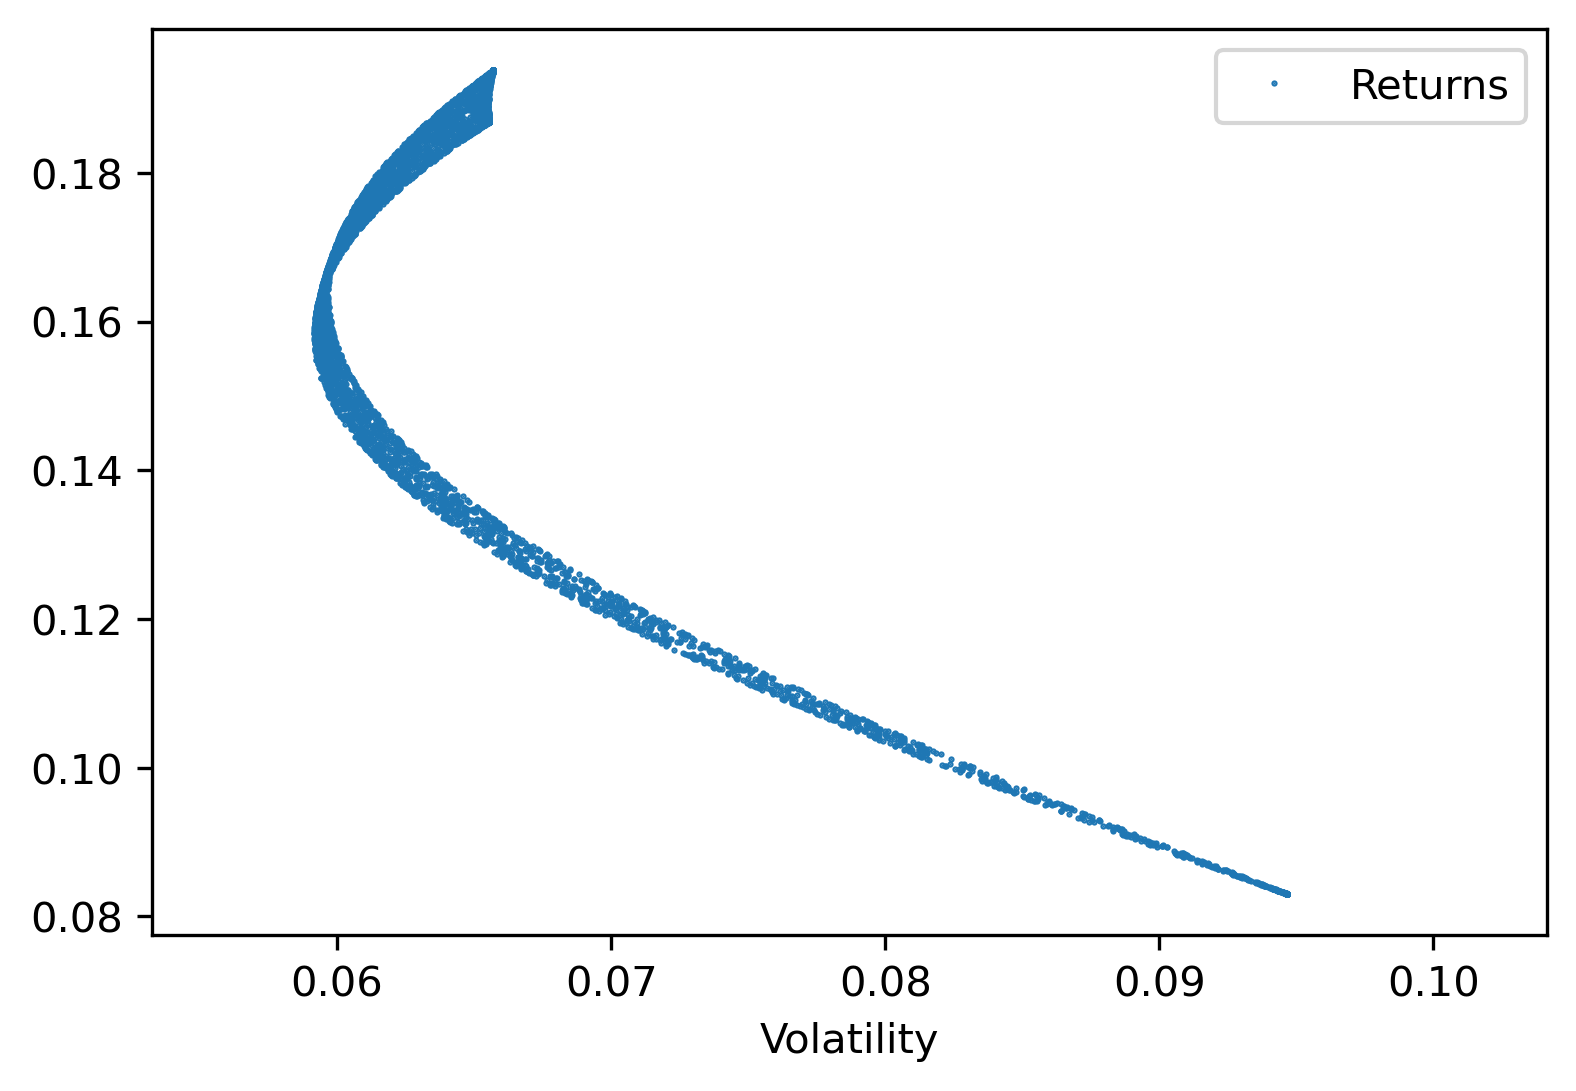

In [13]:
for j in range(1):
    lo_assests = 3
    lo_stock = random.sample(list(etf_result.columns),lo_assests)
    print(lo_stock)
    sim_efN(5000, er_etf[lo_stock].values, cov_etf.loc[lo_stock,lo_stock])


## Optimization (Bonus Question)

Using Mean-Variance Optimization approach to achieve the efficient frontier (minimize standard deviation given each expected return level) by changing weights of your assets. 

You need three or more than three asset inputs for this question.

Then draw the efficient frontier.

#### Function to plot and annotate a single point 

In [14]:
def plotPorfoliosPoint(ao_stockRtn
                     , ao_stockCov
                     , aa_porfoDataList
                     , af_riskFreeRate = 0.03
                     ):
    lo_colList  = np.array(ao_stockCov.columns)
    lo_weightDataFrame = pd.DataFrame()
    lo_performanceDataFrame = pd.DataFrame()
    
    for aa_porfoData in aa_porfoDataList:        
        la_weight  = aa_porfoData['Weights']
        la_rtn     = portfolio_return(la_weight, ao_stockRtn)
        la_vol     = portfolio_vol(la_weight, ao_stockCov)
        la_sharpeR = (la_rtn - af_riskFreeRate)/la_vol
        
        plt.scatter(la_vol, la_rtn, s=100,marker='*')            
        plt.annotate(aa_porfoData["Name"],(la_vol, la_rtn))
        
        #[Start] Portfolio Performance
        lo_tempPerform = pd.DataFrame(data = {aa_porfoData["Name"] : np.array([round(la_vol,4),round(la_rtn,4),round(la_sharpeR,4)])})
        if (len(lo_performanceDataFrame.index) == 0 ):
            lo_performanceDataFrame = lo_tempPerform
        else:
            lo_performanceDataFrame = lo_performanceDataFrame.join(lo_tempPerform)
        #[End] Portfolio Performance
        
        #[Start] Portfolio Weight
        lo_tempWeight = pd.DataFrame(data = {aa_porfoData["Name"] : np.array(np.round(aa_porfoData['Weights'],4))*100})
        if (len(lo_weightDataFrame.index) == 0 ):
            lo_weightDataFrame = lo_tempWeight
        else:
            lo_weightDataFrame = lo_weightDataFrame.join(lo_tempWeight)
        #[End] Portfolio Weight

            
    lo_weightDataFrame.index = lo_colList
    lo_performanceDataFrame.index = ['Volatility','Return','SharpeRatio']
    
    print('Portfolio:')
    display(lo_weightDataFrame)
    print('Portfolio performance:')
    display(lo_performanceDataFrame)
    
    return

#### Function to sim Random Portfolio and plot them

In [15]:
def genRandomPortfo(ao_expRtn
                  , ao_ProfoCov
                  , ai_colCount
                  , af_riskFreeRate
                  , an_points
                    ):
    lo_rtn = dict()
    
    la_weight  = np.array(getWeightN(an_points,ai_colCount))
    la_rtn     = np.array([portfolio_return(w, ao_expRtn) for w in la_weight])
    la_vol     = np.array([portfolio_vol(w, ao_ProfoCov) for w in la_weight])
    la_sharpeR = (la_rtn - af_riskFreeRate)/la_vol
        
    lo_rtn['Weight']      = la_weight
    lo_rtn['Volatility']  = la_vol
    lo_rtn['Return']      = la_rtn
    lo_rtn['SharpeRatio'] = la_sharpeR

    return lo_rtn

#### Function to get Efficient Frontier data

In [16]:
def getEF(ao_expRtn
        , ao_ProfoCov
        , ai_points
           ):
    lo_rtn = dict()
    li_colCount = ao_expRtn.shape[0]
    la_EF_rtn = np.linspace(ao_expRtn.min()
                          , ao_expRtn.max()
                          , ai_points)
    la_EF_vol     = []
    la_EF_weight  = []

    lo_bounds = ((0,1),) * li_colCount
    lo_initMinWeight = [1/li_colCount] * li_colCount
    lo_initMaxWeight = lo_initMinWeight
    
    #[Start] loop through each return to get the weight with min Vol 
    for lf_rtn in la_EF_rtn:
        lo_cons = ({'type':'eq', 'fun': lambda w: np.sum(w)-1}
                 , {'type':'eq', 'fun': lambda w: portfolio_return(w, ao_expRtn) - lf_rtn})

        lo_minResult = optimize.minimize(portfolio_vol
                                       , lo_initMinWeight
                                       , args        = (ao_ProfoCov)
                                       , method      = 'SLSQP'
                                       , bounds      = lo_bounds
                                       , constraints = lo_cons
                                      #, options={'disp': True}
                                         )

        la_EF_vol.append(lo_minResult['fun'])
        la_EF_weight.append(lo_minResult['x'])

        lo_initMinWeight = lo_minResult['x']
    #[End] loop through each return to get the weight with min Vol 

    lo_rtn['Volatility'] = la_EF_vol
    lo_rtn['Return']     = la_EF_rtn
    lo_rtn['Weight']     = la_EF_weight
    
    return lo_rtn

#### Function to plot Random Portfolio, draw Efficient Frontier and then point out the point with max Sharpe Ratio and Min Volatility on the EF

In [17]:
def getReturnAndCov(ao_data, ai_periodPerYr = 12):
     lo_rtn = dict()
     lo_rtn['Return']     = annualize_rets(ao_data, ai_periodPerYr).values
     lo_rtn['Covariance'] = ao_data.cov()
     return lo_rtn


In [18]:
def optm_ef(ao_expRtn
          , ao_ProfoCov
          , af_riskFreeRate = 0.03
          , ai_portfoPts    = 10000
          , ai_efPts        = 500
            ):
    li_colCount = ao_ProfoCov.shape[0]
    lo_colList  = np.array(ao_ProfoCov.columns)
        
    #Start Figure set up
    plt.figure(figsize=(16,9))
    plt.xlabel('Volatility')
    plt.ylabel('Return')
    plt.title('-'.join(lo_colList))
    #End Figure set up
    
    #Start Gen Random Portfoio to form the shape
    lo_randomPortfo = genRandomPortfo(ao_expRtn
                                    , ao_ProfoCov
                                    , li_colCount
                                    , af_riskFreeRate
                                    , ai_portfoPts)

    plt.scatter(lo_randomPortfo['Volatility']
              , lo_randomPortfo['Return']
              , c    = lo_randomPortfo['SharpeRatio']
              , cmap = 'viridis'
              , s    = 1)
    plt.colorbar(label='Sharpe Ratio')
    #End Gen Random Portfoio to form the shape

    #Start Draw EF
    lo_efData = getEF(ao_expRtn,ao_ProfoCov,ai_efPts)
    
    lo_efLine1, = plt.plot(lo_efData['Volatility']
                         , lo_efData['Return']
                         , 'r--'
                         , linewidth = 1
                         , label     = 'Efficient Frontier')
    
    plt.legend(handles=[lo_efLine1])
    #End Draw EF
    
    return lo_efData

#### Max Shape Ratio Portfolio

In [19]:
def MaxSharpeRatioPortfolio(ao_efData, af_riskFreeRate = 0.03):
    la_frontier_rtn     = ao_efData['Return']
    la_frontier_vol     = ao_efData['Volatility']
    lf_frontier_weight  = ao_efData['Weight']
    
    la_frontier_sharpeR = (la_frontier_rtn - af_riskFreeRate)/la_frontier_vol    
    
    li_maxSharpeRIdx    = la_frontier_sharpeR.argmax()
    
    return lf_frontier_weight[li_maxSharpeRIdx]

#### Min Volatility Portfolio

In [20]:
def MinVolatilityPortfolio(ao_efData, af_riskFreeRate = 0.03):
    la_frontier_vol     = ao_efData['Volatility']
    lf_frontier_weight  = ao_efData['Weight']
    li_minVolIdx = np.array(la_frontier_vol).argmin()
    
    return lf_frontier_weight[li_minVolIdx]

#### Plot random N assets 

Portfolio:


,Max Sharpe Ratio Portfolio,Global minimum variance portfolio
Other,0.0,39.28
Telcm,100.0,53.56
Mines,0.0,7.16


Portfolio performance:


,Max Sharpe Ratio Portfolio,Global minimum variance portfolio
Volatility,0.0597,0.0506
Return,0.1228,0.0790
SharpeRatio,1.5529,0.9682


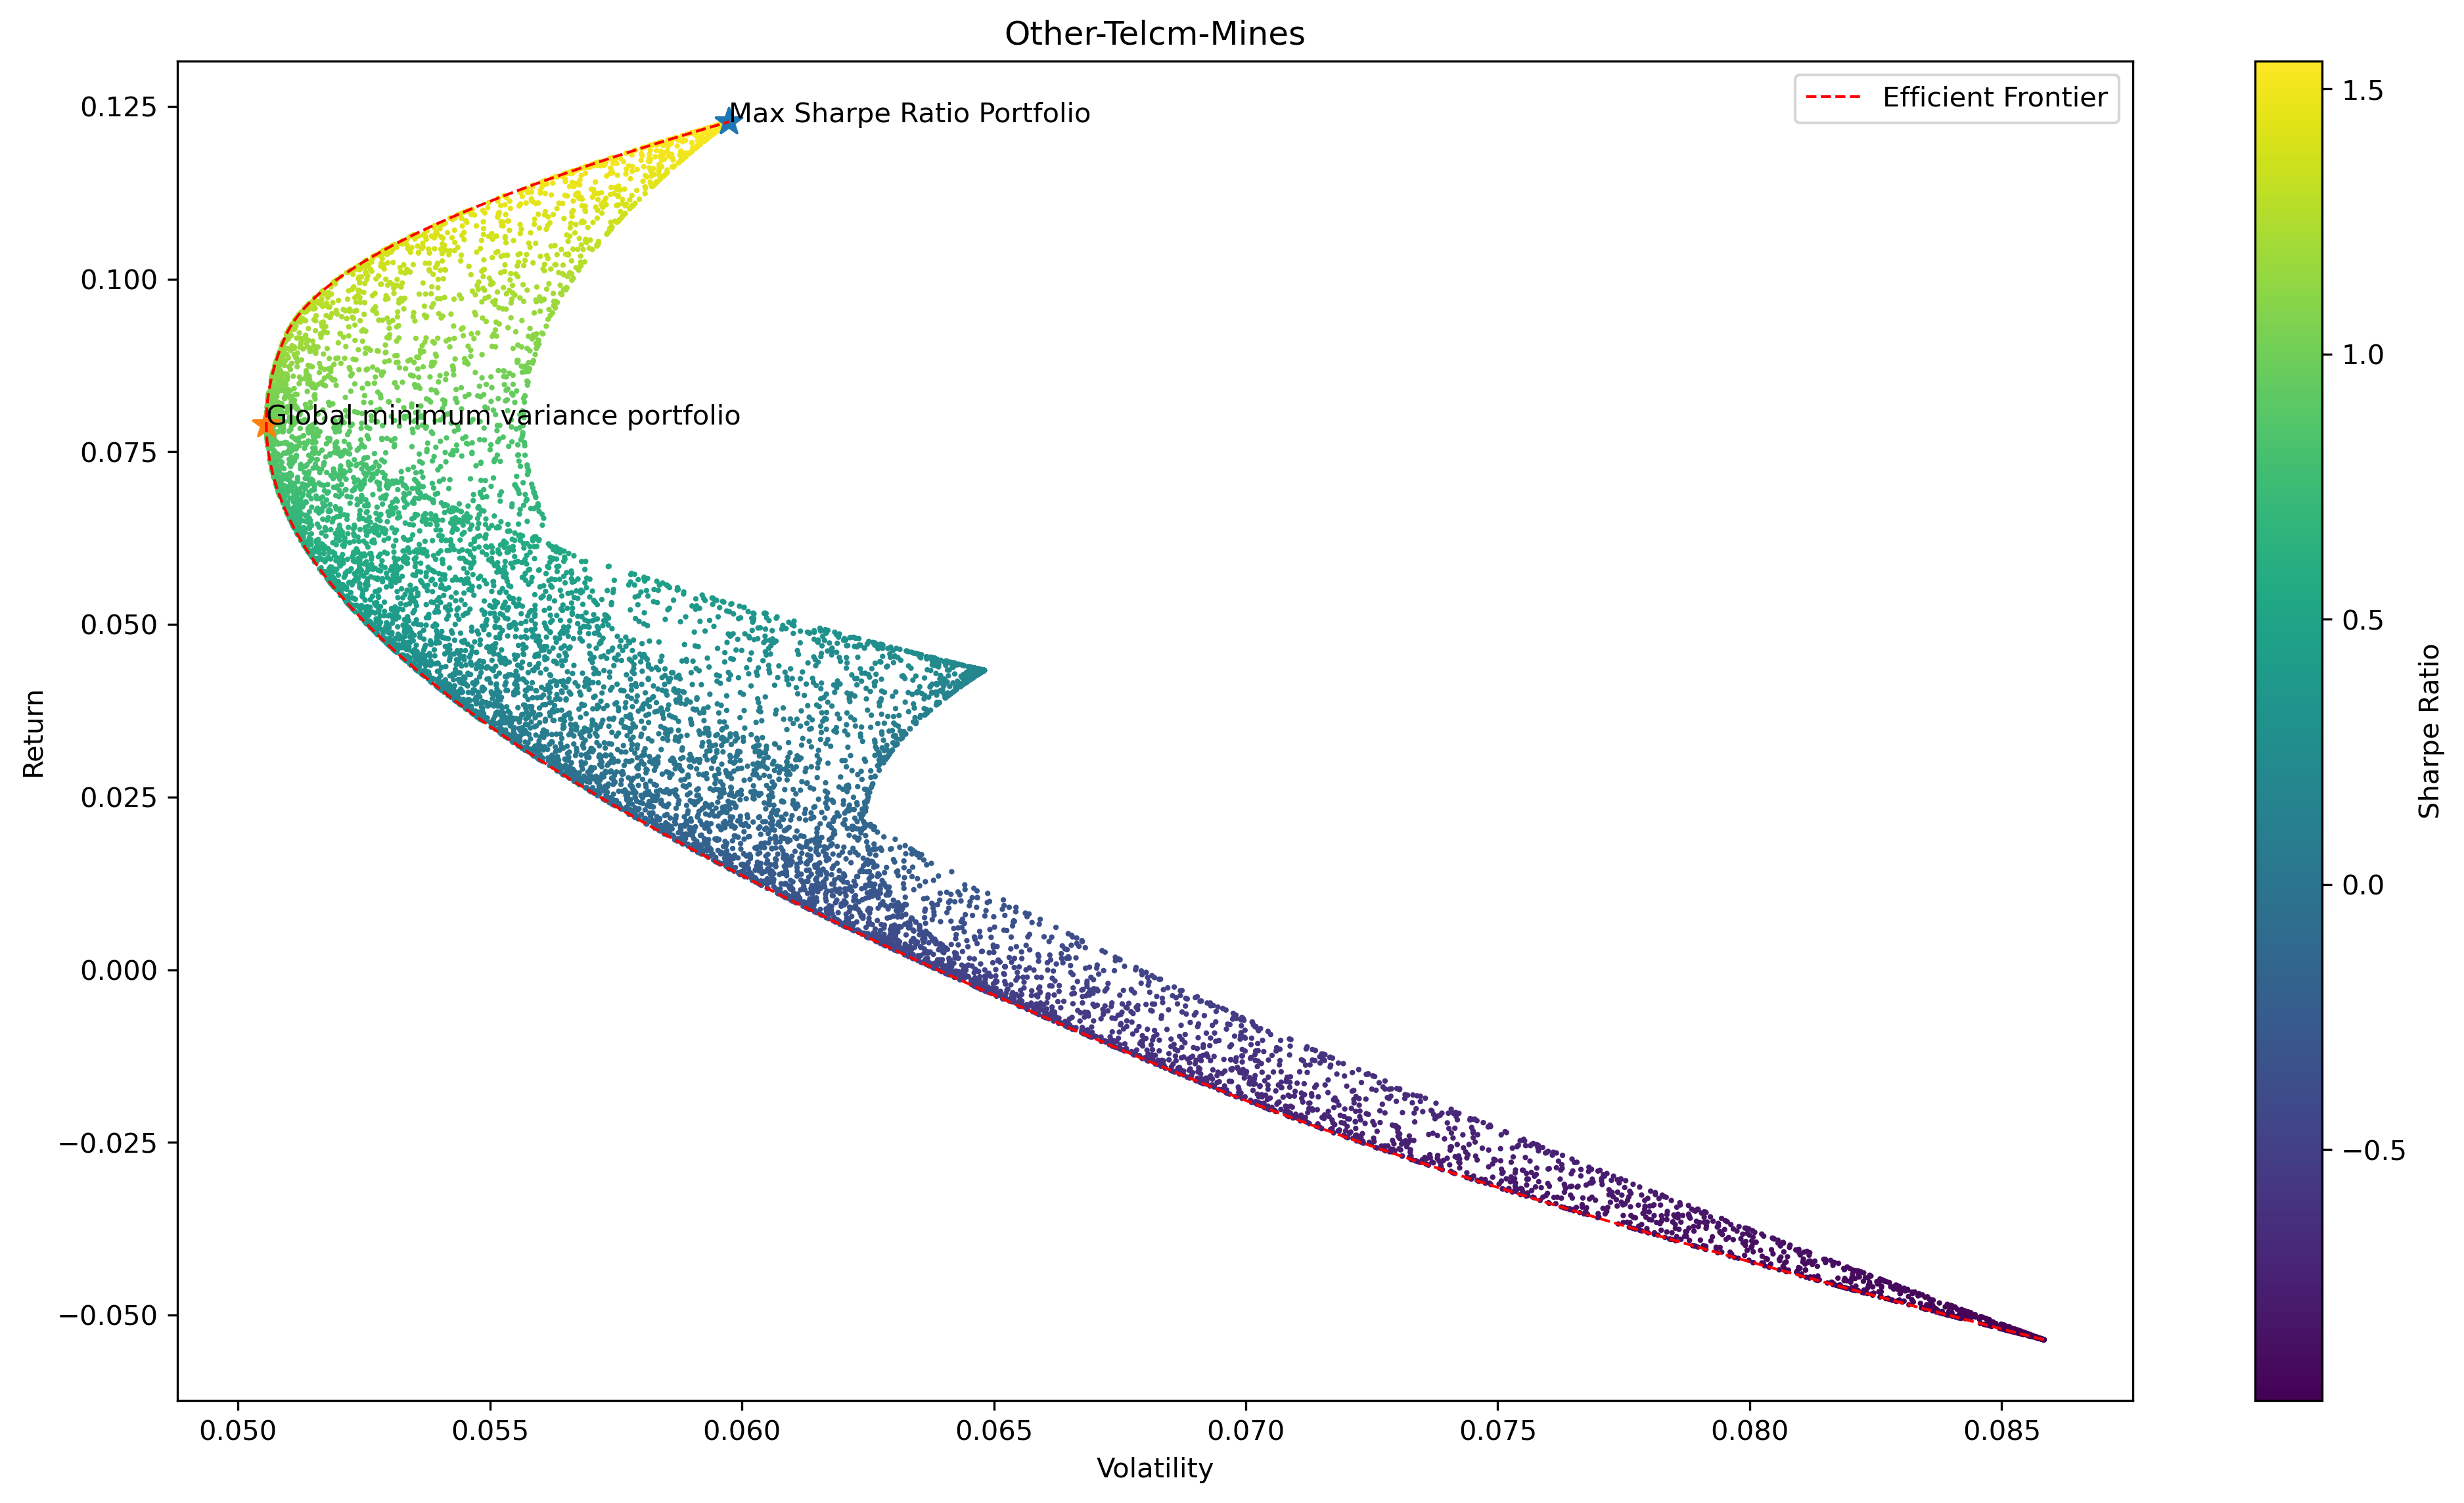

Complete


In [21]:
for j in range(1):
    lo_assests = 3
    lo_stock = random.sample(list(ind.columns),lo_assests)
    lo_rtnCov = getReturnAndCov(ind["1996":"2000"][lo_stock])

    lo_efData = optm_ef(lo_rtnCov['Return'],lo_rtnCov['Covariance'])
        
    plotPorfoliosPoint(lo_rtnCov['Return']
                     , lo_rtnCov['Covariance']
                     , np.array([dict(Weights = MaxSharpeRatioPortfolio(lo_efData) , Name = "Max Sharpe Ratio Portfolio"        )
                               , dict(Weights = MinVolatilityPortfolio(lo_efData)  , Name = "Global minimum variance portfolio" )
                                ])
                      )    
    plt.show()
print('Complete')
    

## Discussion (Bonus Question)

### Simple

#### Equally weighted portfolio

In [22]:
def EquallyWeightedPortfolio(ai_colCount):
    return np.array([1/ai_colCount,]*ai_colCount)

#### Inverse volatility portfolio

In [23]:
def InverseVolatilityPortfolio(ao_ProfoCov):
    li_colCount = ao_ProfoCov.shape[0]
    la_weight = 1/np.array(np.sqrt(np.diag(ao_ProfoCov)))
    return np.array([x/np.sum(la_weight) for x in la_weight])

### Tradition

#### Risk Parity portfolio

In [24]:
def diffOfRiskAndEvenRisk(ao_weights
                        , ao_ProfoCov
                          ):
    
    li_colCount = ao_ProfoCov.shape[0]
    
    lo_totalVol =  portfolio_vol(ao_weights,ao_ProfoCov)
    lo_volMatrix = [1/li_colCount] * li_colCount
    lo_volTarget = np.multiply(lo_totalVol,lo_volMatrix)
    
    # Marginal Risk Contribution
    lo_MRC = ao_ProfoCov@ao_weights.T
    # Risk Contribution
    lo_RC = (lo_MRC*ao_weights.T)/lo_totalVol

    return sum(np.square(lo_RC - lo_volTarget.T))

def RiskParityPortfolio(ao_ProfoCov):
    li_colCount = ao_ProfoCov.shape[0]
    lo_initWeight = [1/li_colCount] * li_colCount
    lo_bounds = ((0,1),) * li_colCount
    lo_cons = ({'type': 'eq' , 'fun': lambda w: np.sum(w)-1})
    
    lo_minResult = optimize.minimize( diffOfRiskAndEvenRisk
                                    , lo_initWeight
                                    , args        = (ao_ProfoCov)
                                    , method      = 'SLSQP'
                                    , bounds      = lo_bounds
                                    , constraints = lo_cons
                                    , tol         = 1e-20
                                    #, options={'disp': True}
                                    )
    return lo_minResult.x
    

#### Maximum diversification portfolio

In [25]:
def ngtDiversificationRatio(ao_weights, ao_ProfoCov):
    lo_weightVol = (np.diag(ao_ProfoCov)**0.5) @ ao_weights.T
    lo_totalVol =  portfolio_vol(ao_weights,ao_ProfoCov)
    lo_diversificationRatio = lo_weightVol/lo_totalVol
    return -lo_diversificationRatio

def MaximumDiversificationPortfolio(ao_ProfoCov):
    li_colCount = ao_ProfoCov.shape[0]
    lo_initWeight = [1/li_colCount] * li_colCount
    lo_bounds = ((0,1),) * li_colCount
    lo_cons = ({'type': 'eq' , 'fun': lambda w: np.sum(w)-1})
    
    lo_maxResult = optimize.minimize(ngtDiversificationRatio
                                   , lo_initWeight
                                   , args        = (ao_ProfoCov)
                                   , method      = 'SLSQP'
                                   , bounds      = lo_bounds
                                   , constraints = lo_cons
                                   , tol         = 1e-20
                                  #, options={'disp': True}                            
                                   )
    return lo_maxResult.x

### Innovative

#### Robust minimum CVaR portfolio (MinCVaR)

In [26]:
def CVaR(ao_weights
       , ao_data
       , af_alpha):
    
    lo_rtnHist = ao_data@ao_weights.T
    
    lo_meanOfHistory = statistics.mean(lo_rtnHist) 
    lo_sdOfHistory = statistics.stdev(lo_rtnHist)
    
    #VaR_n = -norm.ppf(af_alpha, loc=lo_meanOfHistory, scale=lo_sdOfHistory)
    CVaR_n = af_alpha**-1 * norm.pdf(norm.ppf(af_alpha))*lo_sdOfHistory - lo_meanOfHistory
       
    return CVaR_n
    
def MinCVaRPortfolio(ao_data, af_alpha = 0.05):
    
    li_colCount = ao_data.shape[1]
    lo_initWeight = EquallyWeightedPortfolio(li_colCount)
    
    lo_bounds = ((0,1),) * li_colCount
    lo_cons = ({'type': 'eq' , 'fun': lambda w: np.sum(w)-1})
    
    lo_maxResult = optimize.minimize(CVaR
                                   , lo_initWeight
                                   , args        = (ao_data,af_alpha)
                                   , method      = 'SLSQP'
                                   , bounds      = lo_bounds
                                   , constraints = lo_cons
                                   , tol         = 1e-20
                                  #, options={'disp': True}                            
                                   )
    return lo_maxResult.x
    
    

## Run to see all portfolio result

Portfolio:


,Max Sharpe Ratio Portfolio,Global minimum variance portfolio,MinCVaR Portfolio,Equally Weighted Portfolio,Inverse Volatility Portfolio,Risk Parity Portfolio,Maximum Diversification Portfolio
Carry,8.08,26.87,24.95,20.0,22.64,21.70,20.90
Clths,0.00,0.00,0.00,20.0,22.92,21.04,2.49
Coal,41.13,7.74,10.88,20.0,11.00,13.94,22.38
Rtail,50.80,65.38,64.17,20.0,27.11,27.66,45.80
Steel,0.00,0.00,0.00,20.0,16.32,15.65,8.43


Portfolio performance:


,Max Sharpe Ratio Portfolio,Global minimum variance portfolio,MinCVaR Portfolio,Equally Weighted Portfolio,Inverse Volatility Portfolio,Risk Parity Portfolio,Maximum Diversification Portfolio
Volatility,0.0646,0.0483,0.0485,0.0576,0.0531,0.0536,0.0537
Return,0.1915,0.1199,0.1266,0.1412,0.1204,0.1274,0.1514
SharpeRatio,2.4991,1.8616,1.9940,1.9306,1.7016,1.8162,2.2599


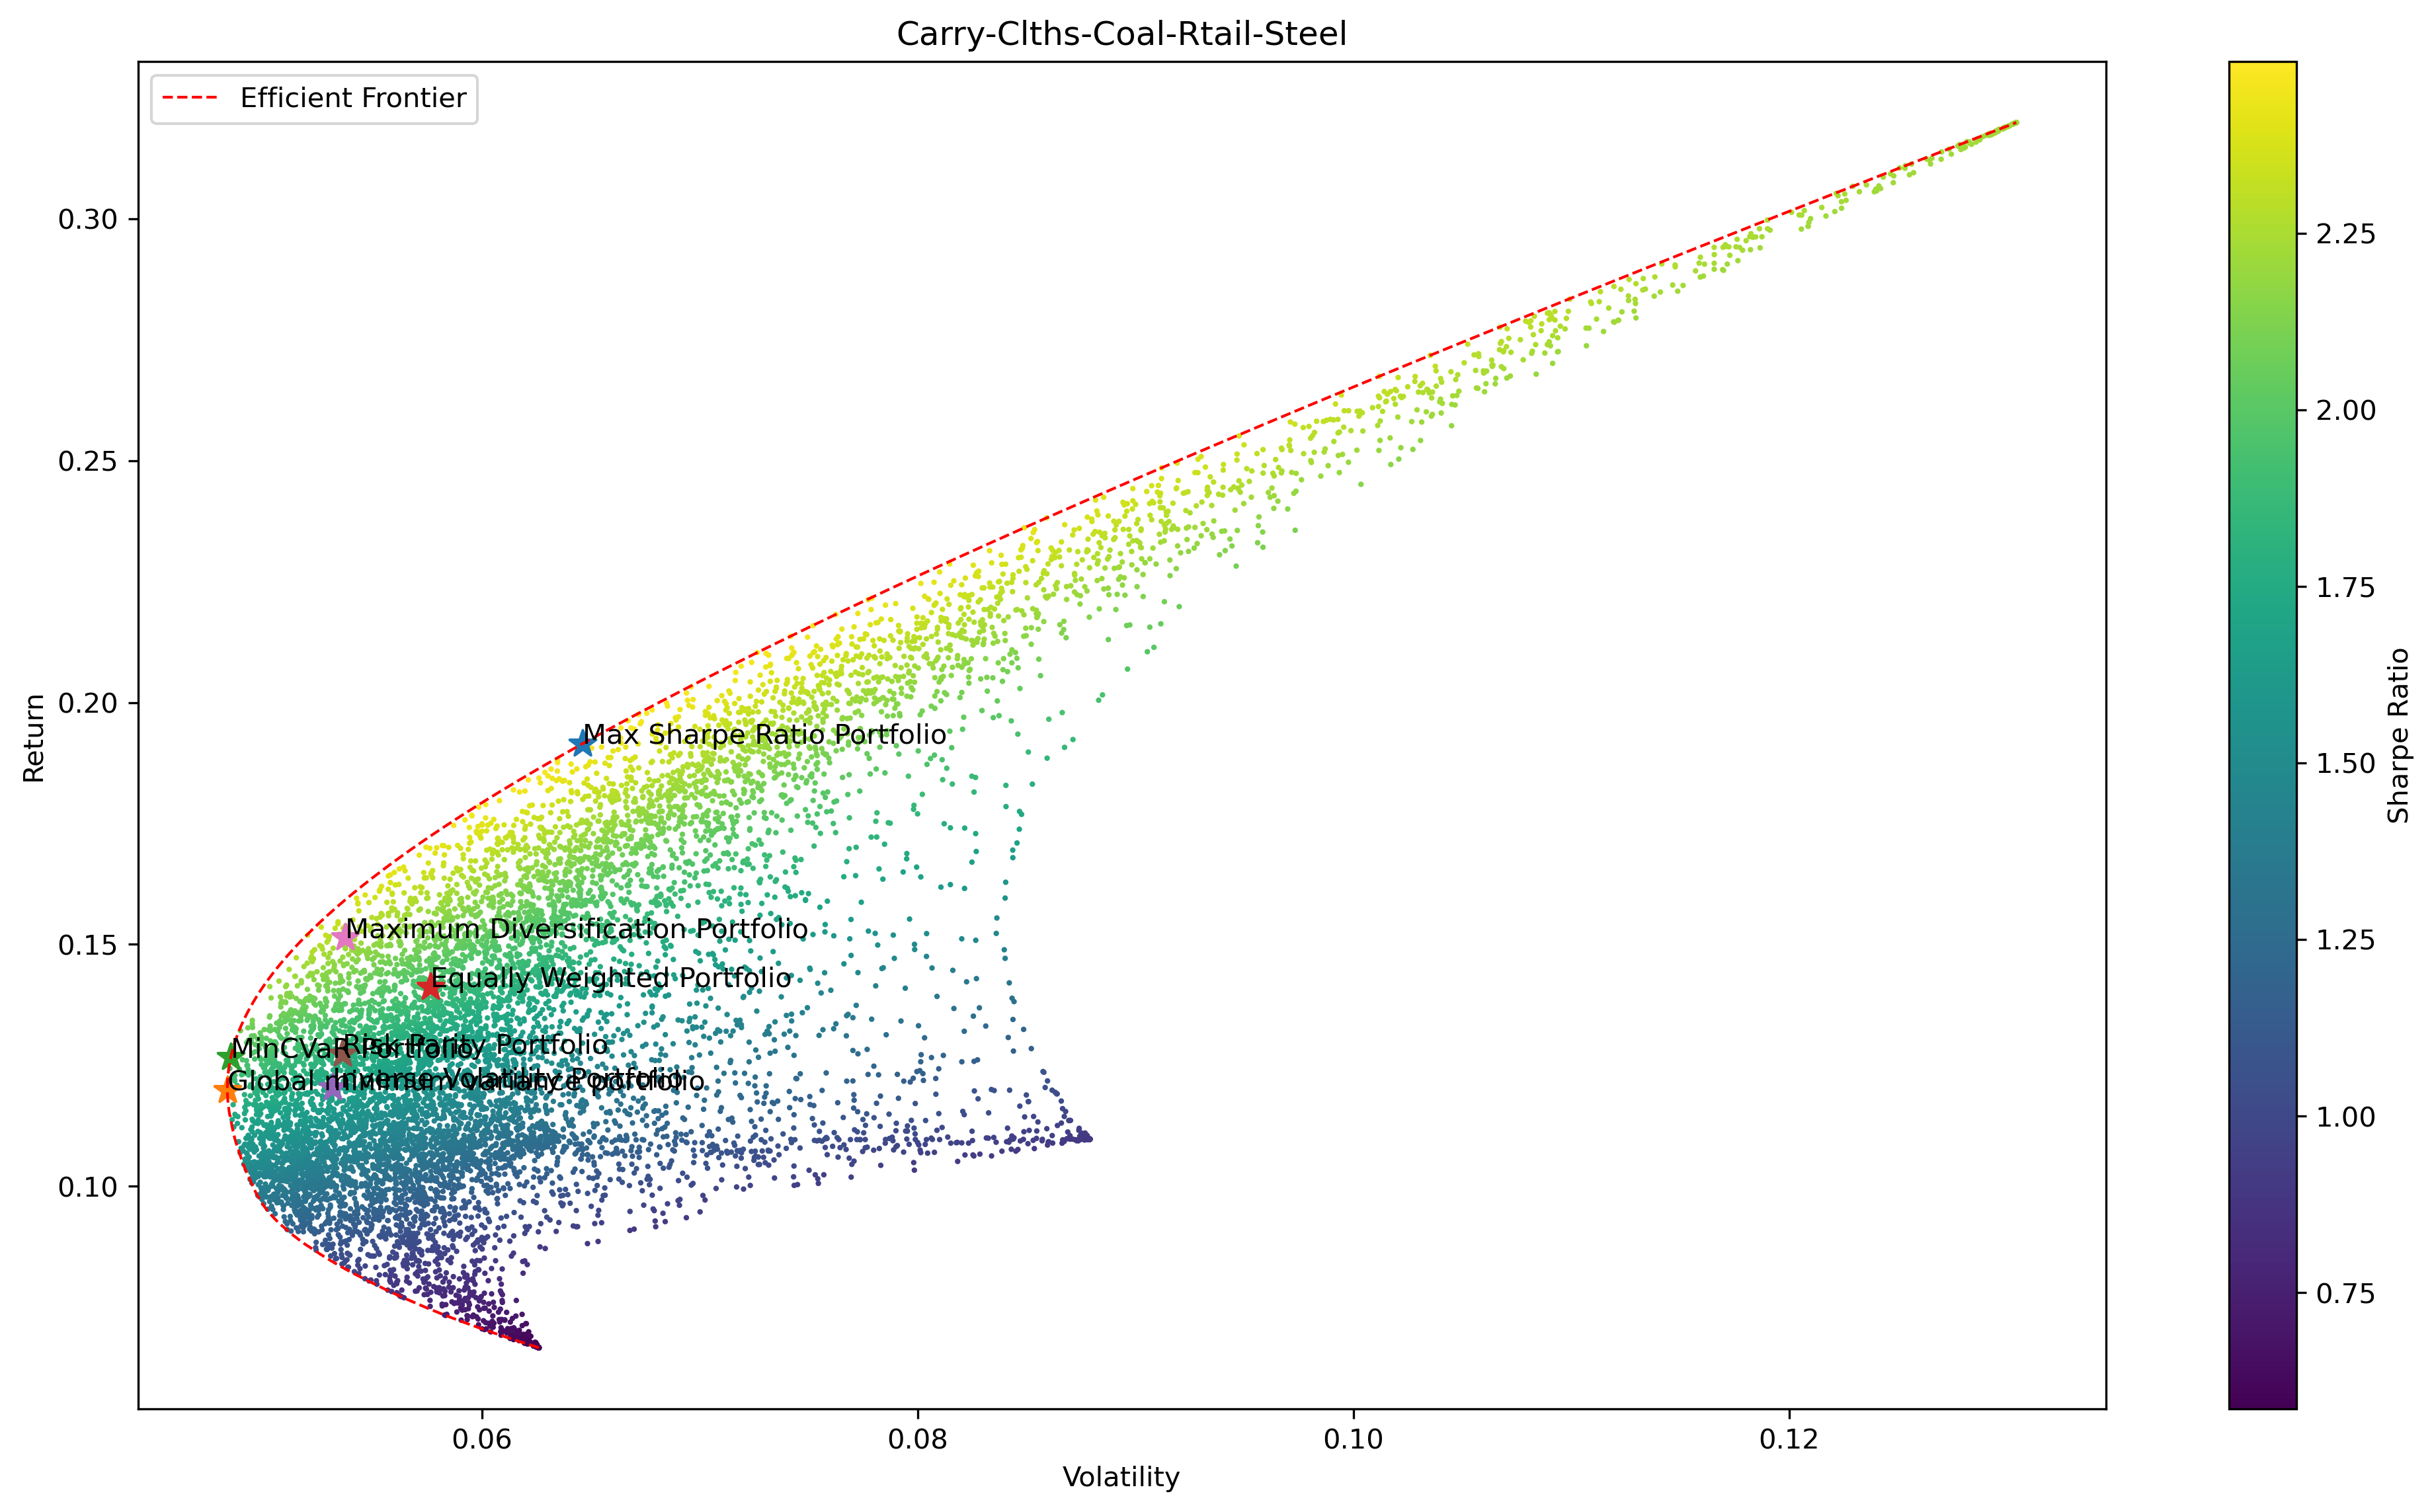

In [27]:
NUMBER_OF_ASSESTS = 5
HISTORY_FROM_YEAR = '1997'
HISTORY_TO_YEAR   = '2007'

for j in range(1):
    
    lo_stock = np.sort(random.sample(list(ind.columns),NUMBER_OF_ASSESTS))
    
    lo_rawData    = ind[HISTORY_FROM_YEAR:HISTORY_TO_YEAR][lo_stock]
    
    lo_rtnCov  = getReturnAndCov(lo_rawData)
    lo_efData = optm_ef(lo_rtnCov['Return'],lo_rtnCov['Covariance'])
    lo_PortfoData = np.array([dict(Weights = MaxSharpeRatioPortfolio(lo_efData)                       , Name = 'Max Sharpe Ratio Portfolio'        )
                            , dict(Weights = MinVolatilityPortfolio(lo_efData)                        , Name = 'Global minimum variance portfolio' )
                            , dict(Weights = MinCVaRPortfolio(lo_rawData)                             , Name = 'MinCVaR Portfolio'                 )
                            , dict(Weights = EquallyWeightedPortfolio(NUMBER_OF_ASSESTS)              , Name = 'Equally Weighted Portfolio'        )
                            , dict(Weights = InverseVolatilityPortfolio(lo_rtnCov['Covariance'])      , Name = 'Inverse Volatility Portfolio'      )
                            , dict(Weights = RiskParityPortfolio(lo_rtnCov['Covariance'])             , Name = 'Risk Parity Portfolio'             )
                            , dict(Weights = MaximumDiversificationPortfolio(lo_rtnCov['Covariance']) , Name = 'Maximum Diversification Portfolio' )
                             ])
    
    plotPorfoliosPoint(lo_rtnCov['Return']
                     , lo_rtnCov['Covariance']
                     , lo_PortfoData)
    plt.show()

Below function will use input stock data to
1. Simulate different portfolios for each month by using past 10 years data
2. Simulate Portfolios Return for that month
3. Repeat above step for every single month


For example, 
- 2008-01 portfolios are simulated by stock data from 1998-01 to 2007-12
- 2008-02 portfolios are simulated by stock data from 1998-02 to 2008-01

- 2018-01 portfolios are simulated by stock data from 2008-01 to 2017-12

In [28]:
def sim_PortfoliosReturn(ao_stockData
                       , ai_yearsOfHistory
                       , ai_simFrom
                       , ai_simTo
                        ):
    li_assestsCount = ao_stockData.shape[1]
    lo_HistoryYearFrom = ai_simFrom - ai_yearsOfHistory
    lo_simulationCount = ai_simTo - ai_simFrom + 1
    lo_HistoryYearTo = lo_HistoryYearFrom + lo_simulationCount
    
    lo_monthPerform = pd.DataFrame()
    
    li_portfoliSetsToRun = ((lo_HistoryYearTo - lo_HistoryYearFrom) * 12)
    li_progress = 0
    li_progressStep = 1/li_portfoliSetsToRun
    
    print(f'Progress:{round(li_progress*100,1)}%', end='\r')
    
    for li_year in range(lo_HistoryYearFrom, lo_HistoryYearTo):
        for li_month in range(1 , 13):# run portfolio each month
            ld_StartTime = time.time()
    
            ls_projectFromMonth = str(li_year) + "-" + str(li_month)
            ls_projectForMonth = str(li_year + ai_yearsOfHistory) + "-" + str(li_month)
    
            if(li_month == 1):
                ls_projectToMonth = str(li_year + ai_yearsOfHistory - 1) + "-12"
            else:
                ls_projectToMonth = str(li_year + ai_yearsOfHistory) + "-" + str(li_month - 1)
    
            #[Start] Simulate different portfolios for each month by using past 5 years data
            lo_historyData = ao_stockData[ls_projectFromMonth:ls_projectToMonth]
            lo_rtnCov  = getReturnAndCov(lo_historyData)
            lo_efData = getEF(lo_rtnCov['Return'],lo_rtnCov['Covariance'],100)
            lo_PortfoData = np.array([dict(Weights = MaxSharpeRatioPortfolio(lo_efData)                       , Name = 'Max Sharpe Ratio Portfolio'        )
                                    , dict(Weights = MinVolatilityPortfolio(lo_efData)                        , Name = 'Global minimum variance portfolio' )
                                    , dict(Weights = MinCVaRPortfolio(lo_historyData)                         , Name = 'MinCVaR Portfolio'                 )
                                    , dict(Weights = EquallyWeightedPortfolio(li_assestsCount)              , Name = 'Equally Weighted Portfolio'        )
                                    , dict(Weights = InverseVolatilityPortfolio(lo_rtnCov['Covariance'])      , Name = 'Inverse Volatility Portfolio'      )
                                    , dict(Weights = RiskParityPortfolio(lo_rtnCov['Covariance'])             , Name = 'Risk Parity Portfolio'             )
                                    , dict(Weights = MaximumDiversificationPortfolio(lo_rtnCov['Covariance']) , Name = 'Maximum Diversification Portfolio' )
                                ])
            #[End] Simulate different portfolios for each month by using past 5 years data
    
            #[Start] Simulate Portfolios Return for that month
            lo_projData = ao_stockData[ls_projectForMonth:ls_projectForMonth]
            lo_projectRtn = lo_projData + 1
    
            lo_portfoPerformanceDataFrame = pd.DataFrame()
    
            for lo_eachPortfo in lo_PortfoData:
                lo_eachprojectRtn = lo_projectRtn*(lo_eachPortfo['Weights'])
                lo_eachprojectRtn = lo_eachprojectRtn.sum(axis = 1, skipna = True)
    
                lo_tempPerform = pd.DataFrame(data = {lo_eachPortfo["Name"] : lo_eachprojectRtn})
                if (len(lo_portfoPerformanceDataFrame.index) == 0 ):
                    lo_portfoPerformanceDataFrame = lo_tempPerform
                else:
                    lo_portfoPerformanceDataFrame = lo_portfoPerformanceDataFrame.join(lo_tempPerform)
    
            if (len(lo_monthPerform.index) == 0 ):
                lo_monthPerform = lo_portfoPerformanceDataFrame
            else:
                lo_monthPerform = lo_monthPerform.append(lo_portfoPerformanceDataFrame)
            #[End] Simulate Portfolios Return for that month
    
            #[Start] Handle progress
            li_portfoliSetsToRun -= 1
            ld_EndTime = time.time()
            ld_singleSetRunTime = ld_EndTime - ld_StartTime
            li_progress += li_progressStep
            print(f'Progress:{round(li_progress*100,1)}%, { round(ld_singleSetRunTime * li_portfoliSetsToRun)  }s to go!!!', end='\r')
            #[End] Handle progress
    return lo_monthPerform - 1

#### Demo here

In [29]:
YEAR_FOR_PROJECTION  = 10    # how many years of data will be used to produce portfolios simulation
SIMULATION_YEAR_FROM = 1988  # Simulation start at this year
SIMULATION_YEAR_TO   = 2018  # Simulation end at this year
NUMBER_OF_ASSESTS    = 10

la_stockList    = np.sort(random.sample(list(ind.columns),NUMBER_OF_ASSESTS))

print('Stock For simulation:')
print(la_stockList)
lo_monthReturn = sim_PortfoliosReturn(ind[la_stockList]
                                    , YEAR_FOR_PROJECTION
                                    , SIMULATION_YEAR_FROM
                                    , SIMULATION_YEAR_TO
                                     )


Stock For simulation:
['Beer' 'ElcEq' 'Games' 'Hlth' 'Hshld' 'Meals' 'Mines' 'Paper' 'Servs'
 'Telcm']


#### Run blow part to plot portfolios' performance

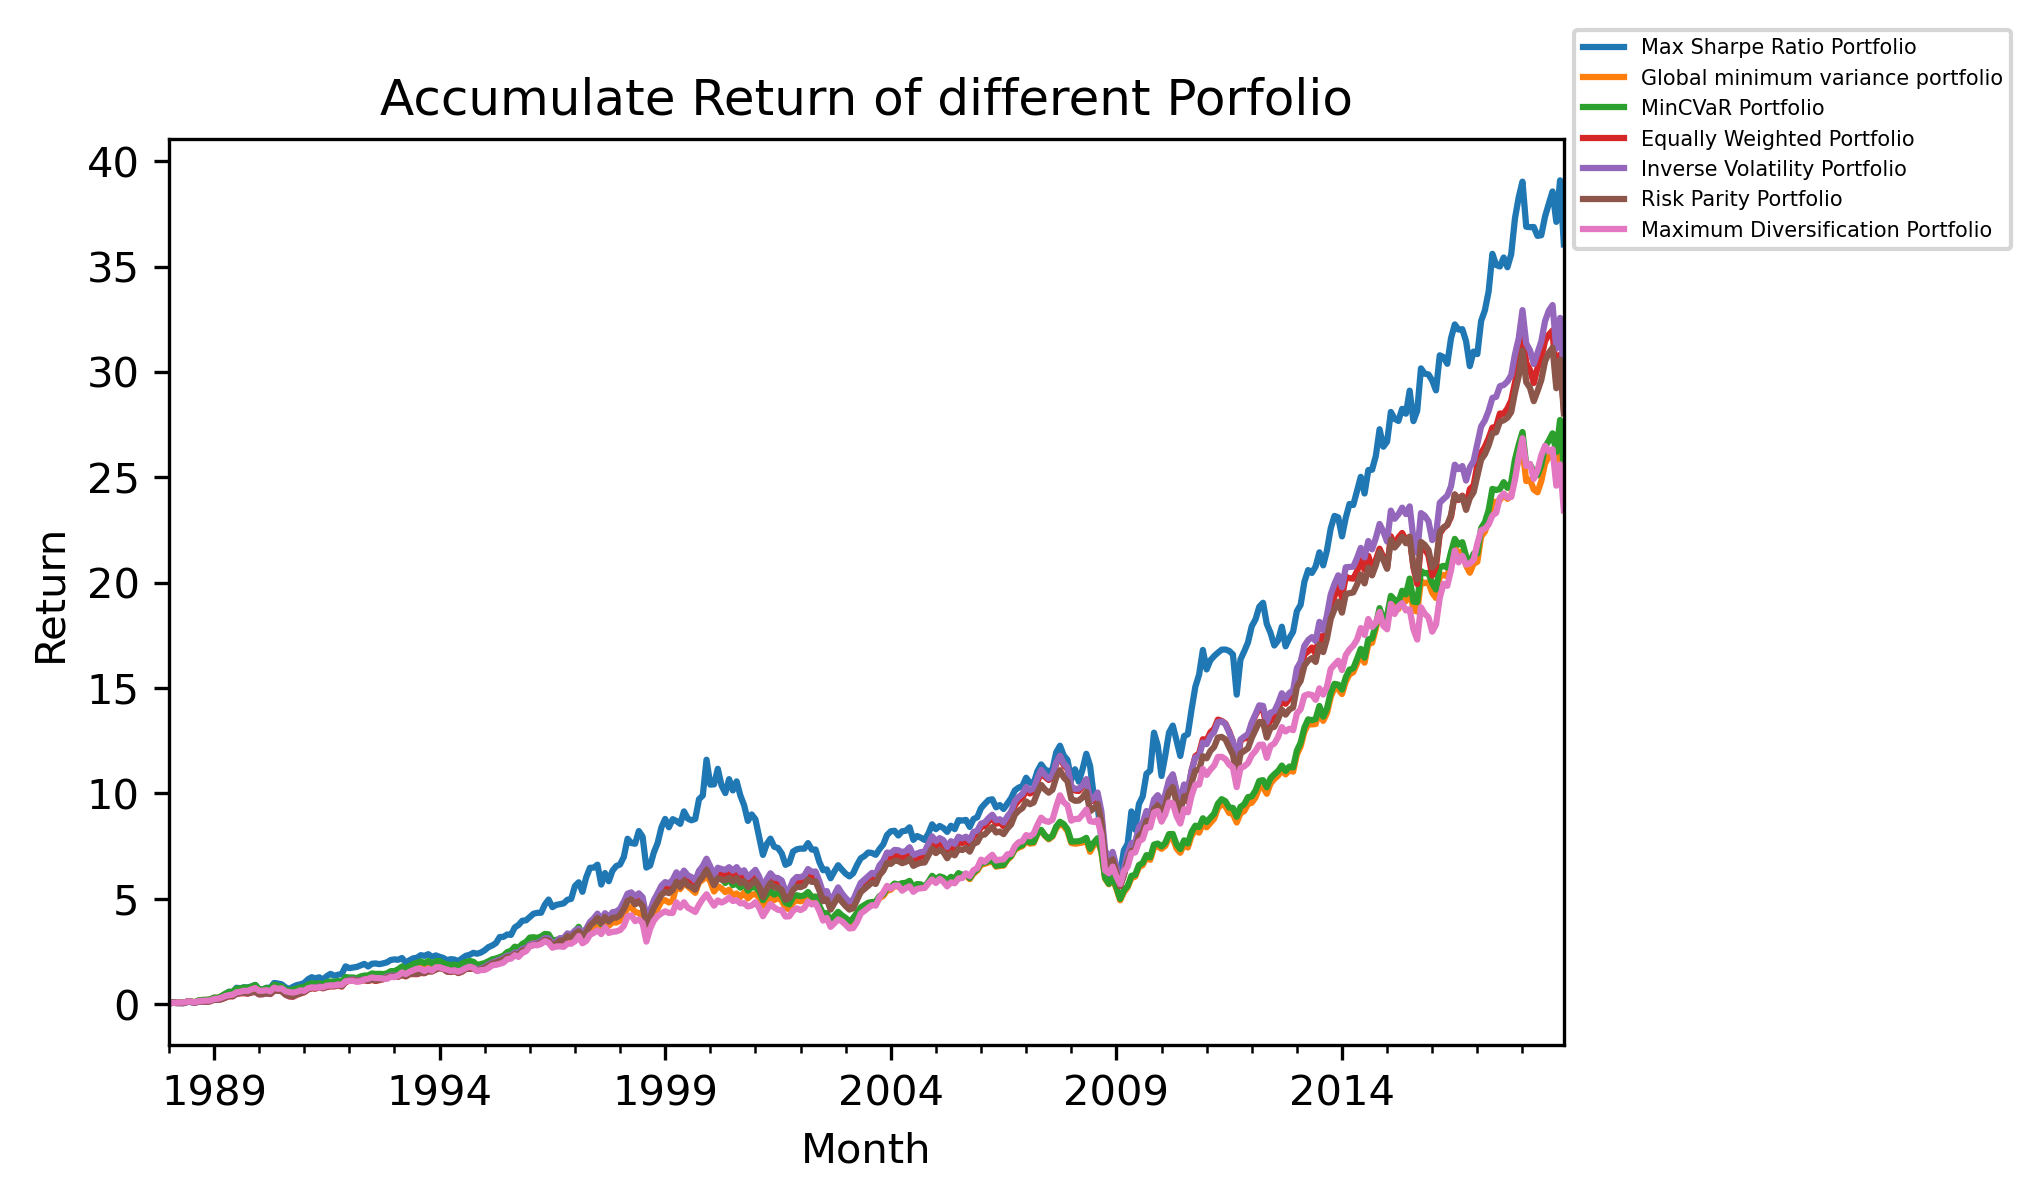

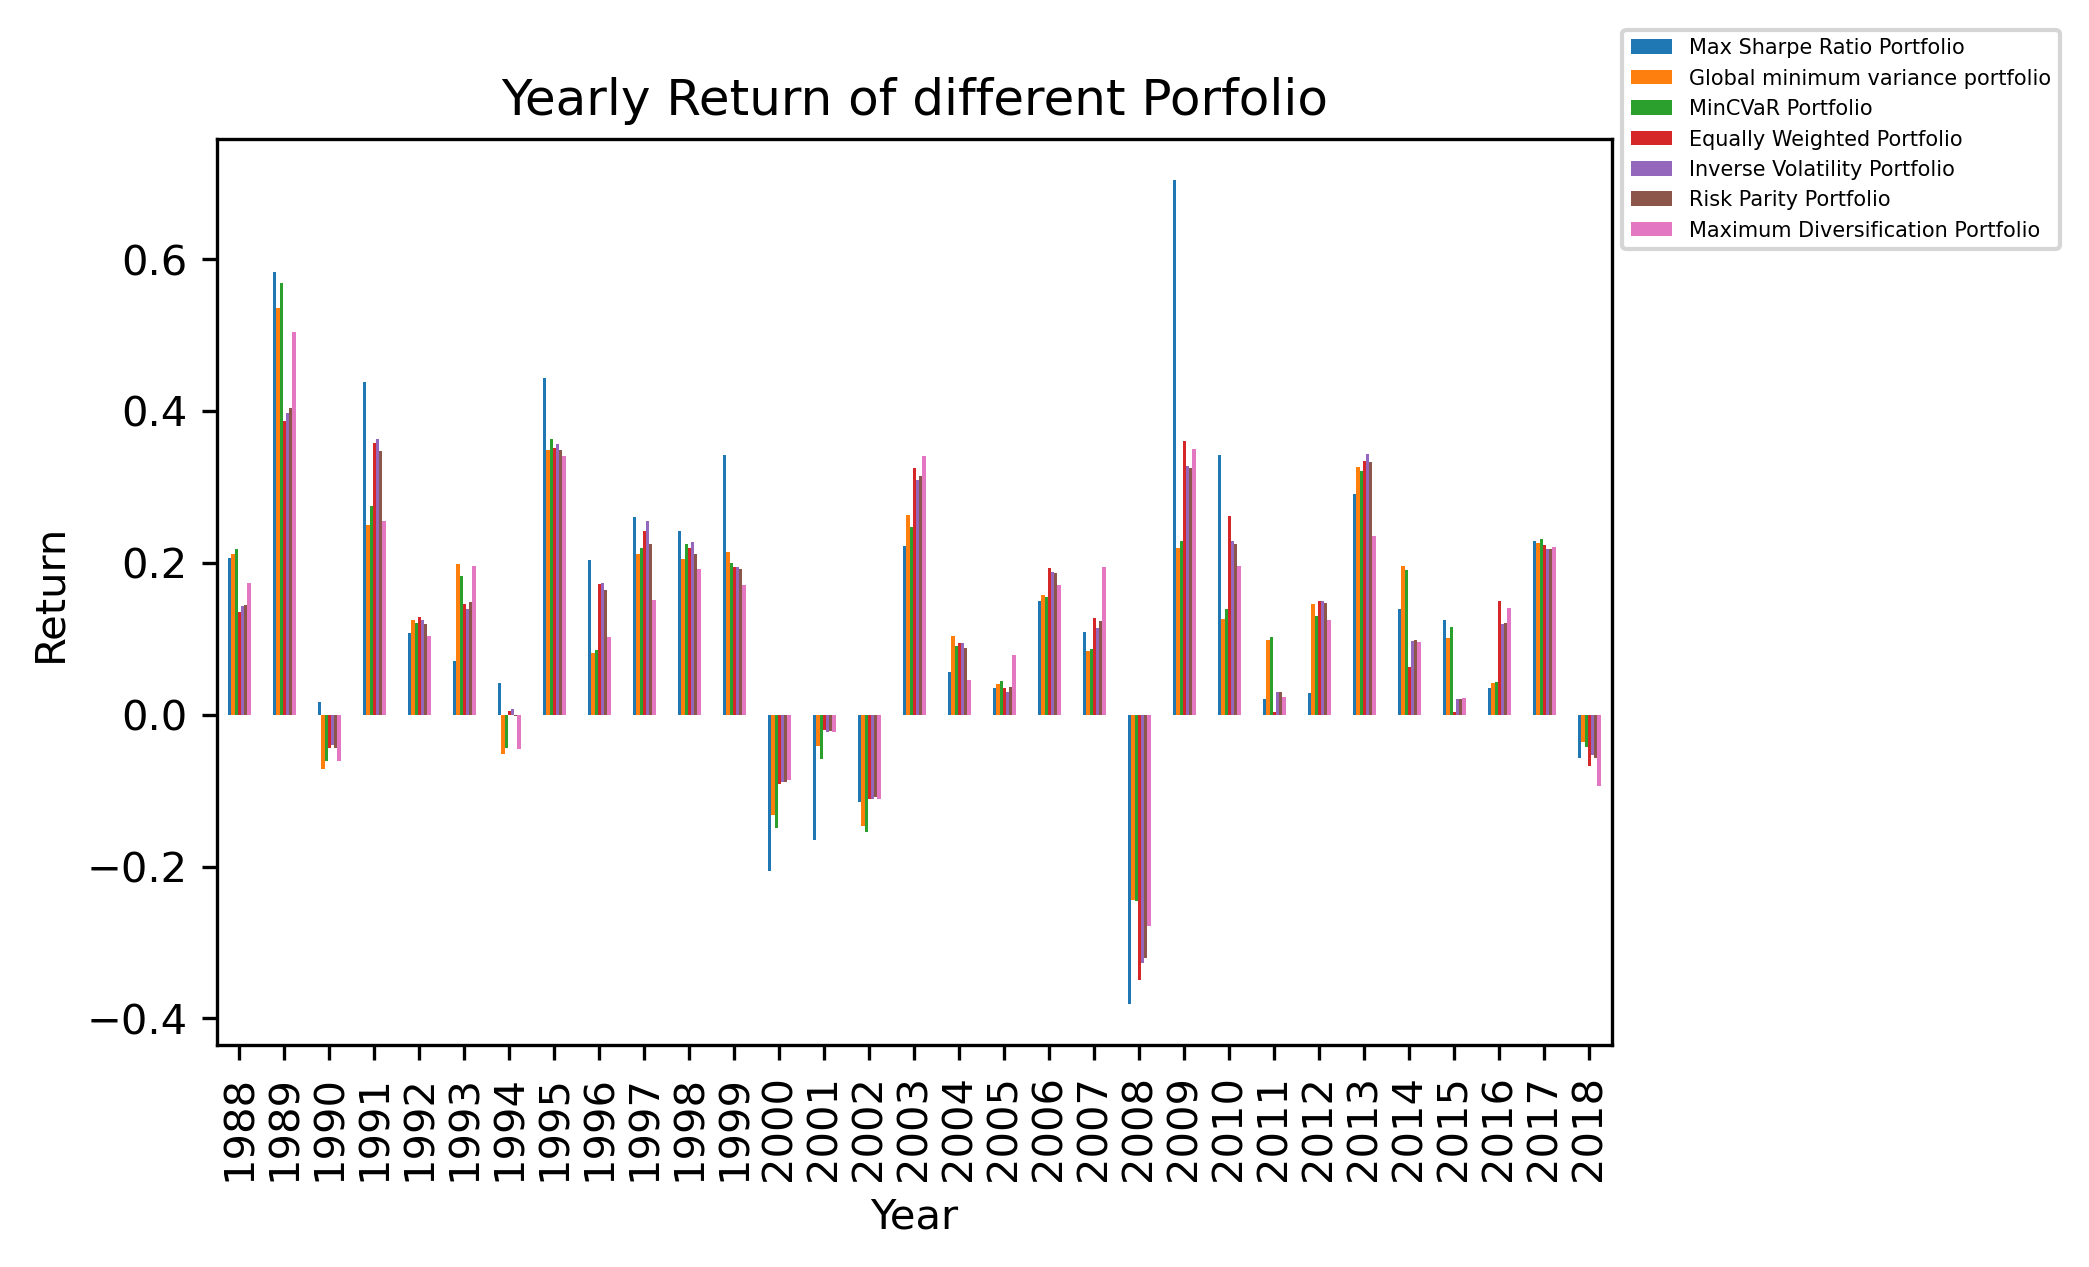

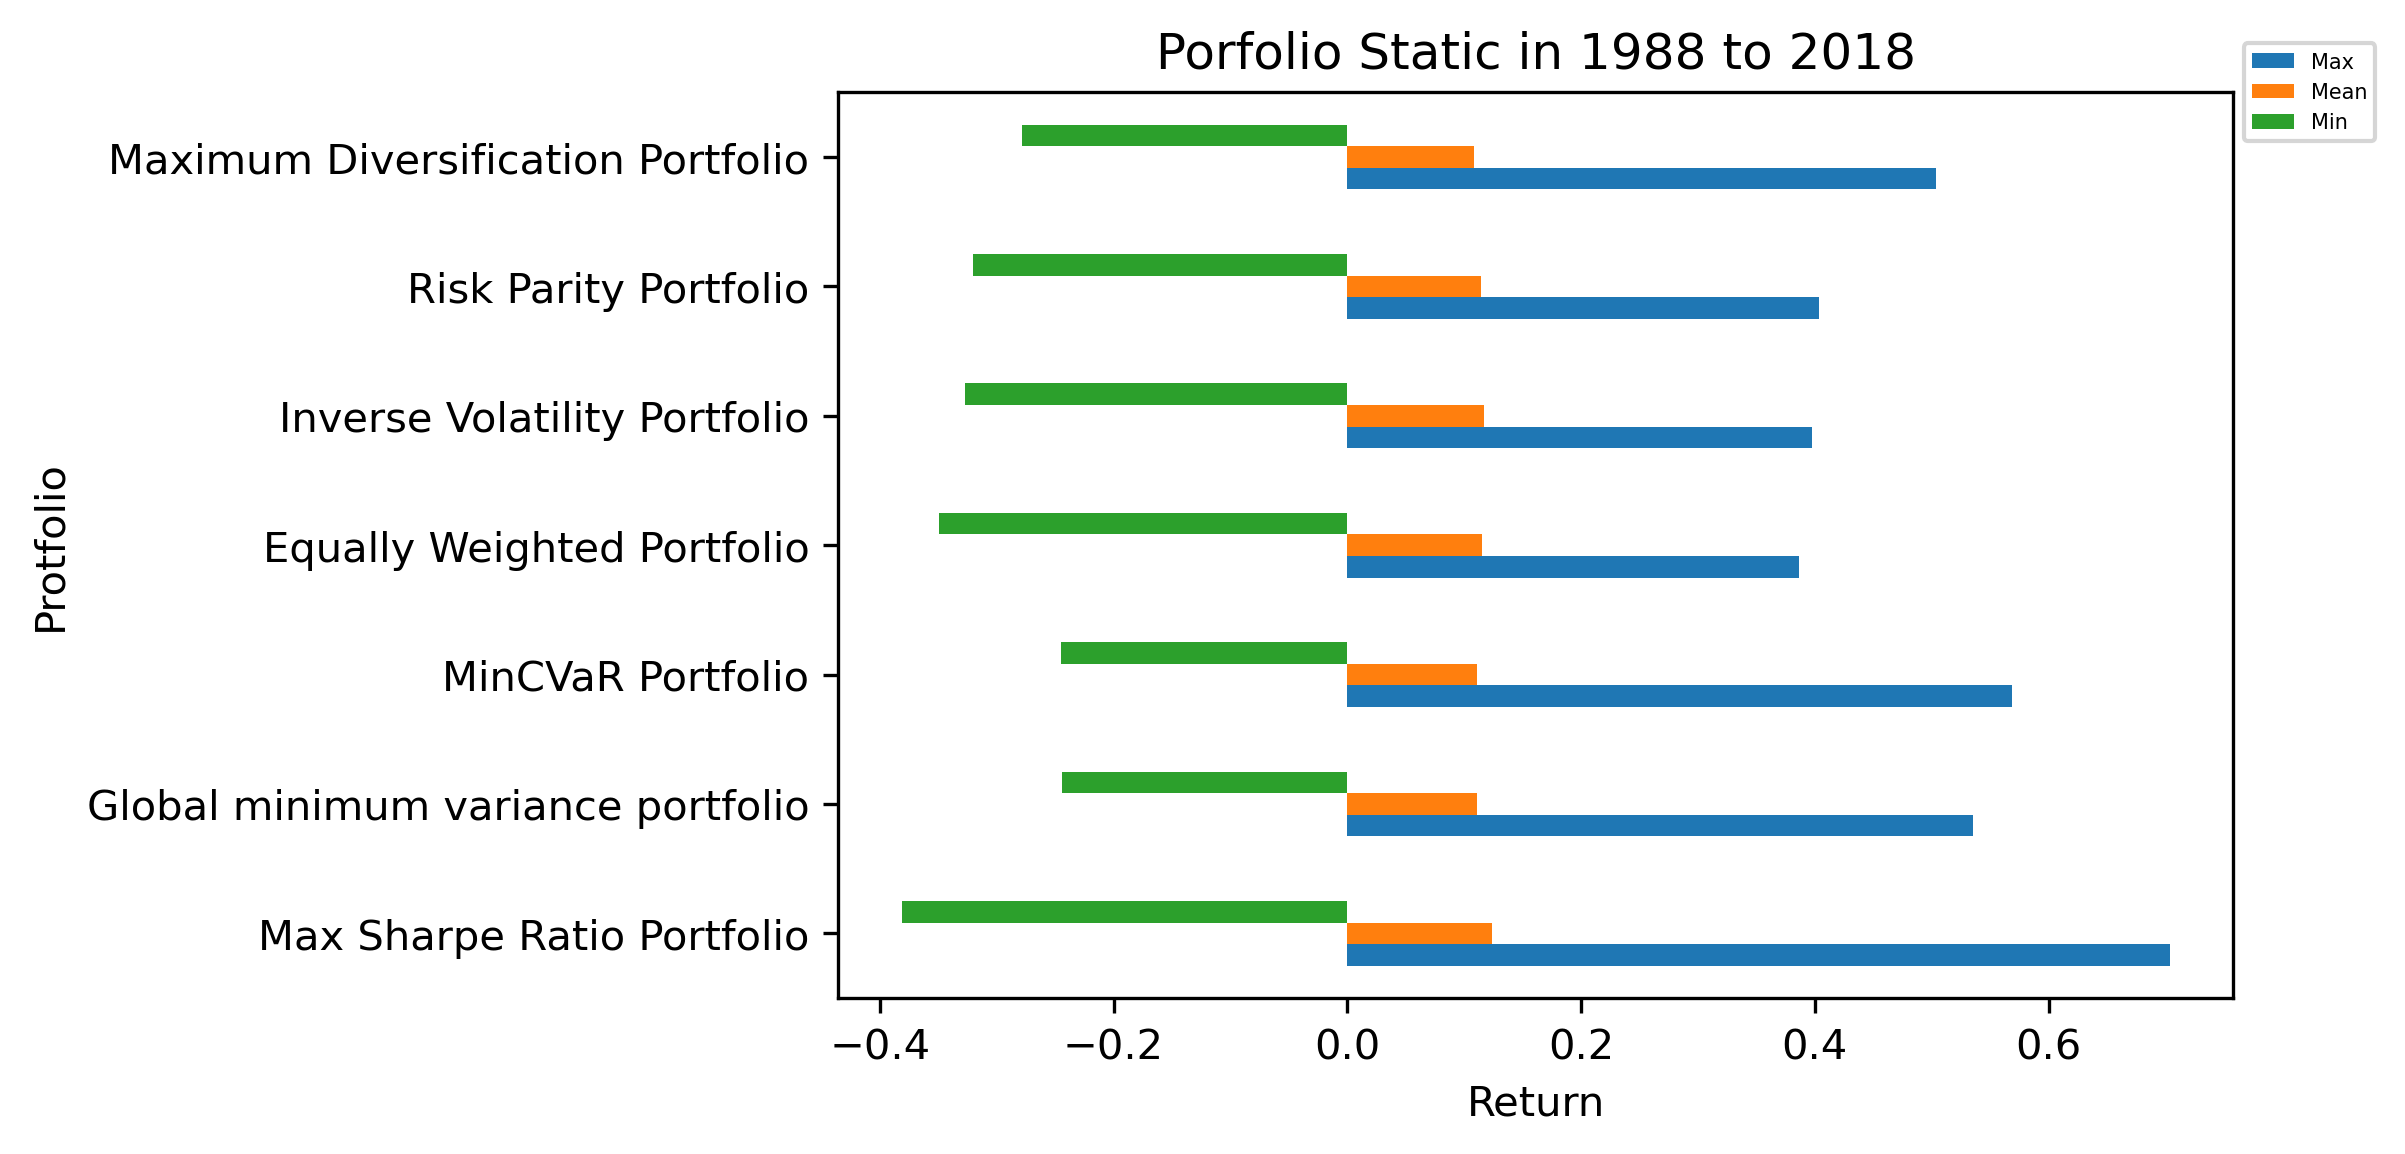

In [30]:
#display(lo_monthReturn)
#[Start] Simulate Portfolio Return of each year
lo_yearReturn = pd.DataFrame()
for li_year in range(SIMULATION_YEAR_FROM,SIMULATION_YEAR_TO + 1):
    lo_tempYearRtn = (lo_monthReturn[str(li_year)]+1).cumprod().tail(1)
    lo_tempYearRtn.index = [li_year]
    if (len(lo_yearReturn.index) == 0 ):
        lo_yearReturn = lo_tempYearRtn
    else:
        lo_yearReturn = lo_yearReturn.append(lo_tempYearRtn)
lo_yearReturn = lo_yearReturn - 1
#[end] Simulate Portfolio Return of each year

lo_monthReturnCumprod = (lo_monthReturn+1).cumprod() - 1

#[Start] Plot portfolios' Accumulate Return, Yearly Return, Mean Return
lo_monthPlot = lo_monthReturnCumprod.plot(title='Accumulate Return of different Porfolio')
lo_monthPlot.set_xlabel("Month")
lo_monthPlot.set_ylabel("Return")
lo_monthPlot.legend(loc='center left', bbox_to_anchor=(1, 1), prop={"size":5})
plt.show()

lo_yearPlot = lo_yearReturn.plot.bar(title='Yearly Return of different Porfolio')
lo_yearPlot.set_xlabel("Year")
lo_yearPlot.set_ylabel("Return")
lo_yearPlot.legend(loc='center left', bbox_to_anchor=(1, 1), prop={"size":5})
plt.show()

li_simulationCount = SIMULATION_YEAR_TO - SIMULATION_YEAR_FROM + 1
lo_PortfolioStat = pd.DataFrame(data = {'Max':lo_yearReturn.max()})
lo_PortfolioStat = lo_PortfolioStat.join(pd.DataFrame(data = {'Mean':((lo_monthReturnCumprod.tail(1)+1)**(1/li_simulationCount)-1).max()}))
lo_PortfolioStat = lo_PortfolioStat.join(pd.DataFrame(data = {'Min':lo_yearReturn.min()}))
lo_PortfolioStatPlot = lo_PortfolioStat.plot.barh(title=f'Porfolio Static in {SIMULATION_YEAR_FROM} to {SIMULATION_YEAR_TO}')
lo_PortfolioStatPlot.set_ylabel("Protfolio")
lo_PortfolioStatPlot.set_xlabel("Return")
lo_PortfolioStatPlot.legend(loc='center left', bbox_to_anchor=(1, 1), prop={"size":5})
plt.show()
#[End] Plot portfolios' Accumulate Return, Yearly Return, Mean Return
